<a href="https://colab.research.google.com/github/ddchristiantan/MLZoomcamp/blob/main/MLZoomcamp_homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [279]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(url)


df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [280]:
filtered_df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [281]:
selected_columns = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

filtered_selected_df = filtered_df[selected_columns]


In [282]:
df = filtered_selected_df.copy()

## Question 1

In [283]:
df.columns[df.isna().any()].tolist()

['total_bedrooms']

In [284]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2

In [285]:
population_median = df['population'].median()
population_median

1195.0

**Validation framework**

In [286]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]


df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[:n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [287]:
y_train_orig = df_train['median_house_value'].values
y_val_orig = df_val['median_house_value'].values
y_test_orig = df_test['median_house_value'].values

y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

**Linear Regression**

In [288]:
def train_linear_regression(X,y):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)

  return w[0], w[1:]


**Base Solution**

In [289]:
base = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income'
]

In [290]:
def prepare_X(df,fill):
  df_num = df[base]
  df_num = df_num.fillna(fill)
  X = df_num.values
  return X

In [291]:
def rmse(y, y_pred):
  error = y_pred - y
  mse = (error ** 2).mean()
  return np.sqrt(mse)

## Question 3

using '0' to fillna

In [292]:
X_train = prepare_X(df_train,0)
w_0, w = train_linear_regression(X_train, y_train)
y_pred_train = w_0 + X_train.dot(w)

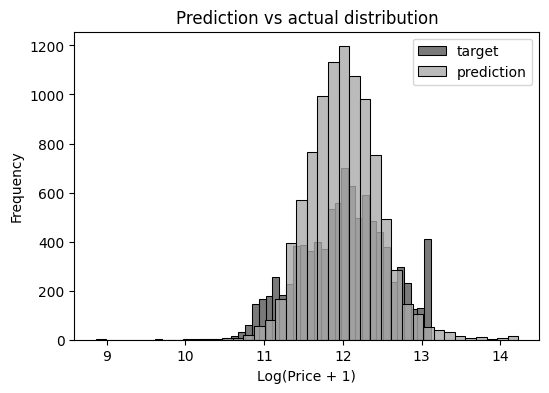

In [293]:
plt.figure(figsize=(6,4))

sns.histplot(y_train, label ='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred_train, label ='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Prediction vs actual distribution')

plt.show()

In [294]:
X_val = prepare_X(df_val,0)
y_pred_val = w_0 + X_val.dot(w)

print('train: ', round(rmse(y_train, y_pred_train),2))
print('val: ', round(rmse(y_val, y_pred_val),2))

train:  0.34
val:  0.33


using 'mean' to fillna

In [295]:
X_train = prepare_X(df_train, df_train['total_bedrooms'].mean())
w_0, w = train_linear_regression(X_train, y_train)
y_pred_train = w_0 + X_train.dot(w)


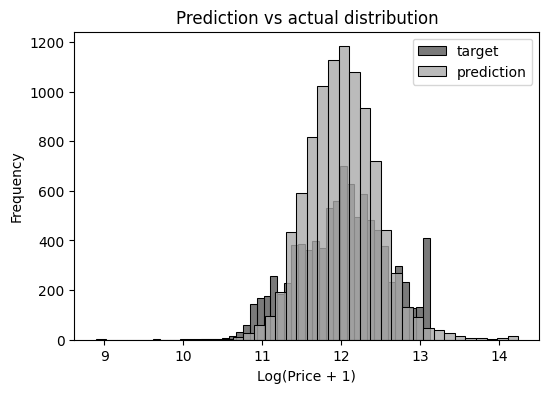

In [296]:
plt.figure(figsize=(6,4))

sns.histplot(y_train, label ='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred_train, label ='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Prediction vs actual distribution')

plt.show()

In [297]:
X_val = prepare_X(df_val,df_val['total_bedrooms'].mean())
y_pred = w_0 + X_val.dot(w)

print('train: ', round(rmse(y_train, y_pred_train),2))
print('val: ', round(rmse(y_val, y_pred_val),2))

train:  0.34
val:  0.33


## Question 4

In [298]:
def reg_train_linear_regression(X,y, r=0.0):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)
  reg = r *np.eye(XTX.shape[0])
  XTX = XTX + reg

  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)

  return w[0], w[1:]

In [299]:
X_train = prepare_X(df_train,0)

In [300]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100]:
  w_0, w = reg_train_linear_regression(X_train, y_train, r=r)
  print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[7], w[7]))

    0, -9.76, 0.18, 0.18
1e-06, -9.76, 0.18, 0.18
0.0001, -9.76, 0.18, 0.18
0.001, -9.74, 0.18, 0.18
 0.01, -9.56, 0.18, 0.18
  0.1, -8.06, 0.18, 0.18
    1, -3.13, 0.19, 0.19
    5, -0.84, 0.19, 0.19
   10, -0.44, 0.19, 0.19
  100, -0.04, 0.19, 0.19


In [301]:
X_train = prepare_X(df_train,0)
X_val = prepare_X(df_val,0)

for r in [0, 0.000001, 0.0001, 0.001]:
  w_0, w = reg_train_linear_regression(X_train, y_train, r=r)
  y_pred = w_0 + X_val.dot(w)
  print('%6s' %r, round(rmse(y_val, y_pred),2))

     0 0.33
 1e-06 0.33
0.0001 0.33
 0.001 0.33


## Question 5

In [302]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

scores = []
train = []

for i in seed_values:
  np.random.seed(i)

  n = len(df)

  n_val = int(0.2 * n)
  n_test = int(0.2 * n)
  n_train = n - (n_val + n_test)

  idx = np.arange(n)
  np.random.shuffle(idx)

  df_shuffled = df.iloc[idx]

  df_train = df_shuffled.iloc[:n_train].copy()
  df_val = df_shuffled.iloc[:n_train:n_train+n_val].copy()
  df_test = df_shuffled.iloc[n_train+n_val:].copy()

  X_train = prepare_X(df_train,0)
  w_0, w = train_linear_regression(X_train, y_train)
  y_pred_train5 = w_0 + X_train.dot(w)


  X_val = prepare_X(df_val,0)
  y_pred_val5 = w_0 + X_val.dot(w)


  train.append((round(rmse(y_train, y_pred_train5),2)))
  scores.append((round(rmse(y_val, y_pred_val5),2)))

std = np.std(scores)
print('val_scores: ', scores)
print('STD: ', round(std,3))

val_scores:  [0.87, 0.86, 0.86, 0.85, 0.86, 0.85, 0.85, 0.87, 0.86, 0.86]
STD:  0.007


## Question 6

In [303]:
np.random.seed(9)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
n_combined = n_val + n_train

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_combined = df_shuffled.iloc[:n_combined].copy()
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[:n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_combined_orig = df_combined['median_house_value'].values
y_train_orig = df_train['median_house_value'].values
y_val_orig = df_val['median_house_value'].values
y_test_orig = df_test['median_house_value'].values

y_combined = np.log1p(df_combined['median_house_value'].values)
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
del df_combined['median_house_value']






X_train = prepare_X(df_combined,0)
w_0, w = reg_train_linear_regression(X_train, y_combined, 0.001)
y_pred_train5 = w_0 + X_train.dot(w)


X_test = prepare_X(df_test,0)
y_pred_test5 = w_0 + X_test.dot(w)


print('RMSE: ', round(rmse(y_val, y_pred_test5),2))


RMSE:  0.48
